In [14]:

# --- Helper para leer imágenes desde GitHub RAW o desde disco (con múltiples rutas) ---
import os, cv2, numpy as np
from urllib.request import urlopen
from urllib.error import HTTPError, URLError

BASE_RAW = "https://raw.githubusercontent.com/MartinAndu/Vision_Computadora_1_CEIA/main/TP3/"
CANDIDATE_PREFIXES = ["", "images/", "template/"]

def _fetch_url(url, flags=cv2.IMREAD_COLOR):
    resp = urlopen(url)
    data = np.asarray(bytearray(resp.read()), dtype="uint8")
    img = cv2.imdecode(data, flags)
    return img

def read_image(path, flags=cv2.IMREAD_COLOR):
    """Lee imagen local si existe; si no, intenta varias rutas en GitHub RAW:
    1) https://raw.githubusercontent.com/MartinAndu/Vision_Computadora_1_CEIA/main/TP3/+path
    2) https://raw.githubusercontent.com/MartinAndu/Vision_Computadora_1_CEIA/main/TP3/+images/path
    3) https://raw.githubusercontent.com/MartinAndu/Vision_Computadora_1_CEIA/main/TP3/+template/path
    Si 'path' ya es URL, la intenta descargar tal cual.
    """
    if isinstance(path, str):
        # 1) Local
        if os.path.exists(path):
            img = cv2.imread(path, flags)
            if img is not None:
                return img

        # 2) URL directa
        if path.startswith("http://") or path.startswith("https://"):
            try:
                return _fetch_url(path, flags)
            except Exception as e:
                print(f"[read_image] Error al leer URL directa: {e}")
                return None

        # 3) Intentos en RAW
        last_err = None
        for pref in CANDIDATE_PREFIXES:
            url = BASE_RAW + pref + path
            try:
                img = _fetch_url(url, flags)
                if img is not None:
                    return img
            except (HTTPError, URLError) as e:
                last_err = e
                continue
            except Exception as e:
                last_err = e
                continue
        if last_err:
            print(f"[read_image] No se pudo obtener '{path}' desde RAW. Último error: {last_err}")
        return None

    # Si no es str, delegar
    return cv2.imread(path, flags)


# Visión por computador I

## Trabajo Práctico 3

Integrantes:
- Andújar Martin a2102
- Ceballos Luciano a2110
- Otonelo Nahuel a2125

___
## 1. Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi.png con el mismo témplate del ítem1
___
Para resolver este problema, realizamos el siguiente procedimiento:

- medimos la relacion de anchos entre el template y el recorte del logo que estamos buscando
- A las imagenes template y coca_multi, le aplicamos un pre procesado que consiste en:
    - aplicar unfiltro gaussiano
    - aplicamos una inversion binaria (este paso fué determinante)
- con la relacion calculada, aplicamos template matching multi escala.
- Aplicamos un filtrado usando la función non_max_suppression
- graficamos los resultados recuadrando cada logo encontrado e indicando la confianza.



In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [16]:

def show_image(image, title="Imagen", cmap_type=None):
    """
    Muestra una imagen directamente en el notebook usando Matplotlib.
    Maneja la conversión de BGR a RGB para imágenes a color.
    """
    # Si la imagen es a color (3 canales), conviértela de BGR a RGB.
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Crea una figura para mostrar la imagen
    plt.figure(figsize=(8, 6))

    # Muestra la imagen. Si cmap_type no es None (ej. 'gray'), lo usa.
    plt.imshow(image, cmap=cmap_type)

    # Añade un título y quita los ejes para una visualización más limpia
    plt.title(title)
    plt.axis('off')

    # Muestra el gráfico en la salida del notebook
    plt.show()


**Análisis exploratorio de la imagen template.**

Medimos la imagen y luego la recortamos para eliminar bordes.


La imagen mide: 400px de ancho y 175px de alto.


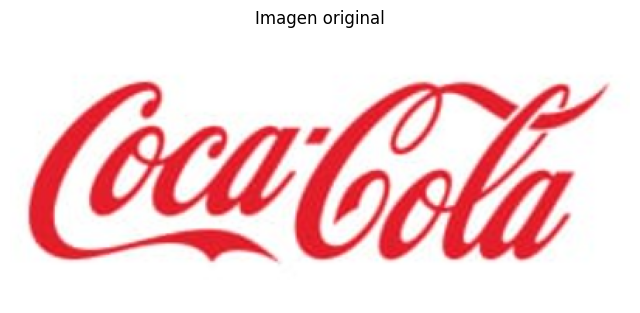

Mostrando el recorte. Presiona una tecla para cerrar.


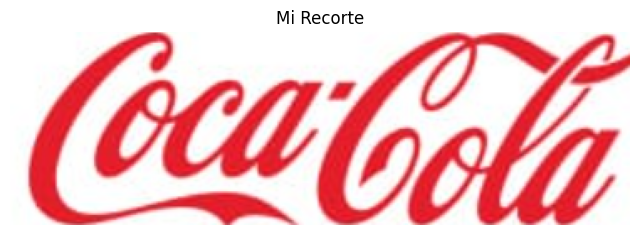

La imagen mide: 369px de ancho y 115px de alto.


In [17]:

image = read_image('pattern.png')

if image is None:
    print("Error: No se pudo cargar la imagen 'pattern.png'.")
else:
    # PASO 1: Medir la imagen y mostrar sus dimensiones
    (alto_total, ancho_total) = image.shape[:2]
    print(f"La imagen mide: {ancho_total}px de ancho y {alto_total}px de alto.")
    show_image(image, title='Imagen original')
    #
    # --- DEFINE AQUÍ TU ÁREA DE RECORTE (con valores iniciales seguros) ---
    x1 = 1
    y1 = 32
    ancho1 = 369
    alto1 = 115
    # --------------------------------------------------------------------

    # Realiza el recorte
    imagen_recortada = image[y1:y1+alto1, x1:x1+ancho1]

    # PASO 2: Comprobar si el recorte fue exitoso ANTES de mostrarlo
    if imagen_recortada.size > 0:
        # Muestra la imagen recortada en una ventana
        print("Mostrando el recorte. Presiona una tecla para cerrar.")
        show_image(imagen_recortada, "Mi Recorte")

        (alto_recorte, ancho_recorte) = imagen_recortada.shape[:2]
        print(f"La imagen mide: {ancho_recorte}px de ancho y {alto_recorte}px de alto.")
        # Opcional: Guarda tu recorte en un nuevo archivo
        cv2.imwrite("pattern_recortado.png", imagen_recortada)
        # print("Recorte guardado como 'mi_template_recortado.png'")
    else:
        print("\nERROR: El recorte ha fallado. Las coordenadas están fuera de los límites de la imagen.")
        print(f"Asegúrate de que 'y+alto' ({y+alto}) sea menor que {alto_total} y que 'x+ancho' ({x+ancho}) sea menor que {ancho_total}.")

**Exploración de la imágen coca_multi**

Encontramos el logo en una de las botellas y medimos el tamaño, ancho y alto. Estas variables las guardamos para calcular la relación entre el template y el logo.

Si bien el algoritmo implementado para este punto (punto 2 del tp) encuentra automaticamente la escala aplicando un for, sabiendo exactamente el tamaño del logo que buscamos en coca_multi, buscaremos en ese entorno.

La imagen mide: 799px de ancho y 598px de alto.


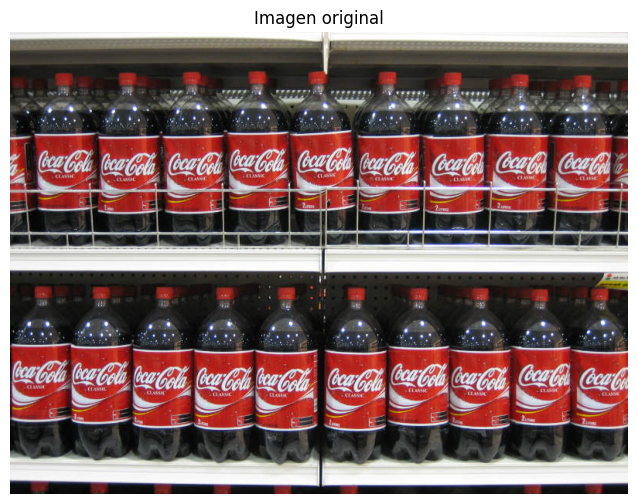

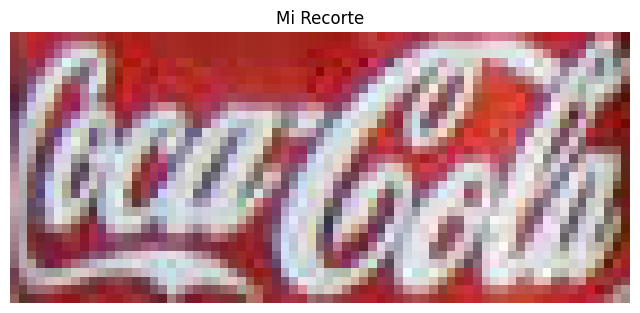

La imagen mide: 71px de ancho y 31px de alto.


In [18]:

image2 = read_image('coca_multi.png')

if image2 is None:
    print("Error: No se pudo cargar la imagen 'pattern.png'.")
else:
    # PASO 1: Medir la imagen y mostrar sus dimensiones
    (alto_total, ancho_total) = image2.shape[:2]
    print(f"La imagen mide: {ancho_total}px de ancho y {alto_total}px de alto.")
    show_image(image2, title='Imagen original')
    #
    # --- DEFINE AQUÍ TU ÁREA DE RECORTE (con valores iniciales seguros) ---
    x = 118
    y = 156
    ancho = 71
    alto = 31

    '''x = 0
    y = 0
    ancho = 120
    alto = 300'''
    # --------------------------------------------------------------------

    # Realiza el recorte
    imagen_recortada = image2[y:y+alto, x:x+ancho]

    # PASO 2: Comprobar si el recorte fue exitoso ANTES de mostrarlo
    if imagen_recortada.size > 0:
        # Muestra la imagen recortada en una ventana

        show_image(imagen_recortada, "Mi Recorte")

        (alto_recorte, ancho_recorte) = imagen_recortada.shape[:2]
        print(f"La imagen mide: {ancho_recorte}px de ancho y {alto_recorte}px de alto.")
        # Opcional: Guarda tu recorte en un nuevo archivo
        #cv2.imwrite("pattern_recortado.png", imagen_recortada)
        # print("Recorte guardado como 'mi_template_recortado.png'")
    else:
        print("\nERROR: El recorte ha fallado. Las coordenadas están fuera de los límites de la imagen.")
        print(f"Asegúrate de que 'y+alto' ({y+alto}) sea menor que {alto_total} y que 'x+ancho' ({x+ancho}) sea menor que {ancho_total}.")

**Encontrando la relación:**

In [19]:
relacion = ancho/ancho1
print(relacion)

0.19241192411924118


## Algoritmo principal:

[INFO] Procesando la plantilla...
[INFO] Procesando la imagen de búsqueda...


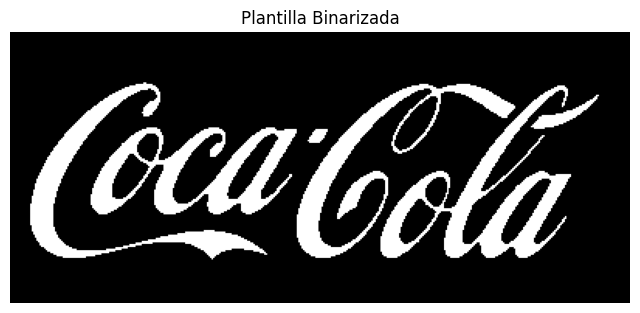

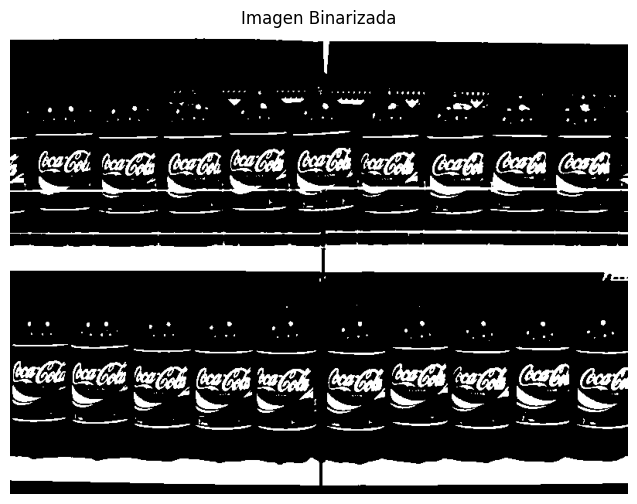


[INFO] Buscando coincidencias...
Buscando en un rango de escala de 0.0924 a 0.2424

[INFO] Se encontraron 483 detecciones en bruto.
[INFO] Después de NMS, quedaron 17 detecciones finales.

[INFO] Mostrando resultados finales.


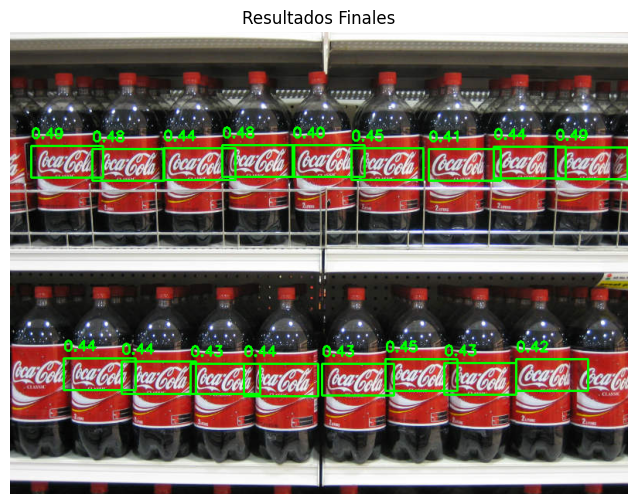

In [20]:
def non_max_suppression(boxes, overlapThresh):
    # ... (código de la función sin cambios) ...
    if len(boxes) == 0: return []
    boxes = np.array(boxes, dtype="float")
    pick = []
    x1, y1, x2, y2, scores = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3], boxes[:, 4]
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(scores)
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        overlap = (w * h) / area[idxs[:last]]
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))
    return boxes[pick]



# PRE-PROCESAMIENTO DE LA PLANTILLA ---
print("[INFO] Procesando la plantilla...")
template = read_image('pattern.png')
template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
template_gray = cv2.GaussianBlur(template_gray, (3, 3), 0)
# Umbral Invertido: el texto oscuro se vuelve blanco, el fondo claro se vuelve negro.
_, template_binary = cv2.threshold(template_gray, 127, 255, cv2.THRESH_BINARY_INV)
(tH_orig, tW_orig) = template_binary.shape[:2]

# PRE-PROCESAMIENTO DE LA IMAGEN DE BÚSQUEDA ---
print("[INFO] Procesando la imagen de búsqueda...")
image = read_image('coca_multi.png')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_gray = cv2.GaussianBlur(image_gray, (3, 3), 0)

_, image_binary = cv2.threshold(image_gray, 150, 255, cv2.THRESH_BINARY)

# Visualizamos las siluetas para verificar
show_image(template_binary, title="Plantilla Binarizada", cmap_type='gray')
show_image(image_binary, title="Imagen Binarizada", cmap_type='gray')

# --- PASO 3: BÚSQUEDA MULTI-ESCALA INFORMADA con la relación calculada antes---
print("\n[INFO] Buscando coincidencias...")
detections = []

# Define tu escala ideal y el margen de búsqueda
margen = 0.1
min_scale = relacion - margen
max_scale = relacion + 0.5*margen

print(f"Buscando en un rango de escala de {min_scale:.4f} a {max_scale:.4f}")

for scale in np.linspace(min_scale, max_scale, 20):
    new_width = max(1, int(tW_orig * scale))
    new_height = max(1, int(tH_orig * scale))
    resized_template = cv2.resize(template_binary, (new_width, new_height))

    result = cv2.matchTemplate(image_binary, resized_template, cv2.TM_CCOEFF_NORMED)

    threshold = 0.35  # <-- PARÁMETRO CLAVE. Empezamos más alto con este método.
    (y_points, x_points) = np.where(result >= threshold)

    for (x, y) in zip(x_points, y_points):
        detections.append((x, y, x + new_width, y + new_height, result[y, x]))

# --- PASO 4 y 5: FILTRADO Y DIBUJO ---
print(f"\n[INFO] Se encontraron {len(detections)} detecciones en bruto.")
final_logos = non_max_suppression(detections, 0.3)
print(f"[INFO] Después de NMS, quedaron {len(final_logos)} detecciones finales.")

for (startX, startY, endX, endY, confidence) in final_logos:
    cv2.rectangle(image, (int(startX), int(startY)), (int(endX), int(endY)), (0, 255, 0), 2)
    cv2.putText(image, f"{confidence:.2f}", (int(startX), int(startY) - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

# --- PASO 6: MOSTRAR RESULTADO FINAL ---
print("\n[INFO] Mostrando resultados finales.")
show_image(image, title="Resultados Finales")

El algoritmo encontró la mayoria de los logos en la botella.

___
## 2. Obtener una detección del logo en cada imagen sin falsos positivos
___
Ahora generalizaremos el procedimiento usado antes para encontrar los logos en las otras imágenes.

Analizamos todas las imágenes como hicimos al principio buscando la relación de tamaño.

La imagen original mide: 400px de ancho y 175px de alto.


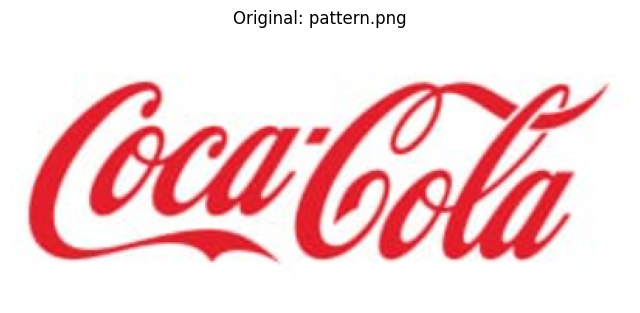

Mostrando el recorte...


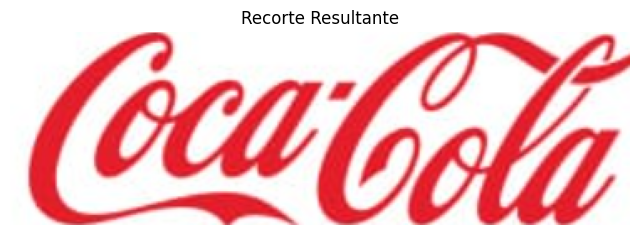

La imagen recortada mide: 369px de ancho y 115px de alto.
Recorte guardado como 'pattern_recortado.png'

La función se ejecutó correctamente.


In [21]:

def recortar_y_guardar_imagen(nombre_archivo_entrada, nombre_archivo_salida, x=0, y=0, ancho=0, alto=0):
    """
    Carga una imagen, la recorta según las coordenadas dadas, muestra
    los resultados y guarda el recorte en un nuevo archivo.

    Parámetros:
    - nombre_archivo_entrada (str): Ruta de la imagen a recortar.
    - nombre_archivo_salida (str): Ruta donde se guardará la imagen recortada.
    - x, y, ancho, alto (int): Coordenadas y dimensiones del recorte.
    """
    # Carga la imagen que quieres recortar
    image = read_image(nombre_archivo_entrada)

    if image is None:
        print(f"Error: No se pudo cargar la imagen '{nombre_archivo_entrada}'.")
        return None # Devuelve None si falla

    # PASO 1: Medir y mostrar la imagen original
    (alto_total, ancho_total) = image.shape[:2]
    print(f"La imagen original mide: {ancho_total}px de ancho y {alto_total}px de alto.")
    show_image(image, title=f'Original: {nombre_archivo_entrada}')

    # Realiza el recorte
    imagen_recortada = image[y:y+alto, x:x+ancho]

    # PASO 2: Comprobar, mostrar y guardar el recorte
    if imagen_recortada.size > 0:
        print("Mostrando el recorte...")
        show_image(imagen_recortada, title="Recorte Resultante")

        (alto_recorte, ancho_recorte) = imagen_recortada.shape[:2]
        print(f"La imagen recortada mide: {ancho_recorte}px de ancho y {alto_recorte}px de alto.")

        # Guarda el recorte en el archivo de salida
        cv2.imwrite(nombre_archivo_salida, imagen_recortada)
        print(f"Recorte guardado como '{nombre_archivo_salida}'")

        return imagen_recortada # Devuelve la imagen recortada si tiene éxito
    else:
        print("\nERROR: El recorte ha fallado. Las coordenadas están fuera de los límites.")
        print(f"Asegúrate de que 'y+alto' ({y+alto}) sea menor que {alto_total} y que 'x+ancho' ({x+ancho}) sea menor que {ancho_total}.")
        return None # Devuelve None si falla

# --- Ejemplo de Uso ---

# Define los parámetros para el recorte
archivo_original = 'pattern.png'
archivo_destino = 'pattern_recortado.png'
x1 = 1
y1 = 32
ancho1 = 369
alto1 = 115

# Llama a la función con tus parámetros
mi_recorte = recortar_y_guardar_imagen(archivo_original, archivo_destino, x=x1, y=y1, ancho=ancho1, alto=alto1)

# Puedes comprobar si la función devolvió una imagen
if mi_recorte is not None:
    print("\nLa función se ejecutó correctamente.")

La imagen original mide: 207px de ancho y 500px de alto.


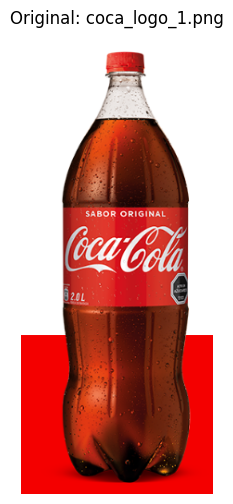

Mostrando el recorte...


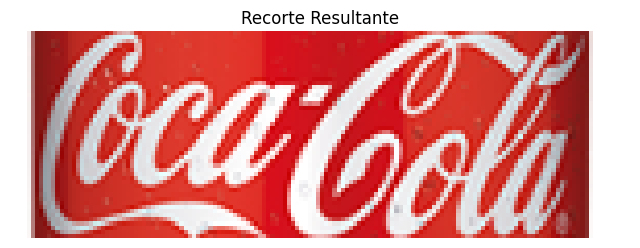

La imagen recortada mide: 150px de ancho y 50px de alto.
Recorte guardado como 'coca_logo_1_recortada.png'


In [22]:
# Llama a la función con tus parámetros
mi_recorte = recortar_y_guardar_imagen('coca_logo_1.png', 'coca_logo_1_recortada.png', x=40, y=210, ancho=150, alto=50)

La imagen original mide: 233px de ancho y 363px de alto.


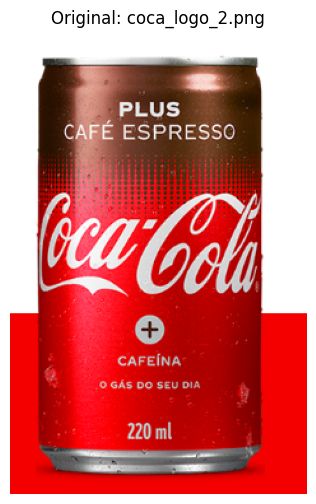

Mostrando el recorte...


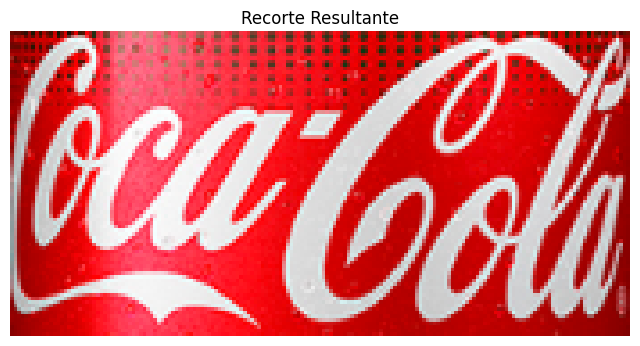

La imagen recortada mide: 173px de ancho y 85px de alto.
Recorte guardado como 'coca_logo_2_recortada.png'


In [23]:
# Llama a la función con tus parámetros
mi_recorte = recortar_y_guardar_imagen('coca_logo_2.png', 'coca_logo_2_recortada.png', x=23, y=125, ancho=173, alto=85)

La imagen original mide: 715px de ancho y 493px de alto.


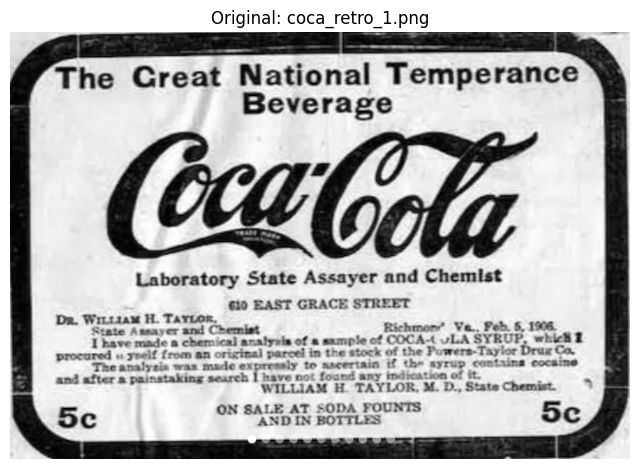

Mostrando el recorte...


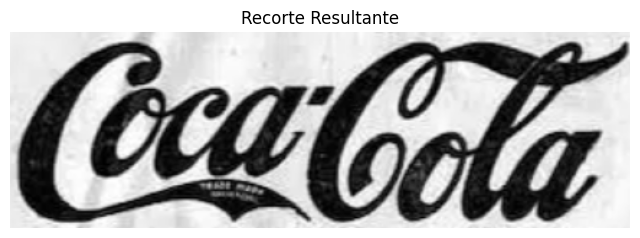

La imagen recortada mide: 505px de ancho y 160px de alto.
Recorte guardado como 'coca_retro_1_recortada.png'


In [24]:
# Llama a la función con tus parámetros
mi_recorte = recortar_y_guardar_imagen('coca_retro_1.png', 'coca_retro_1_recortada.png', x=105, y=107, ancho=505, alto=160)

La imagen original mide: 715px de ancho y 429px de alto.


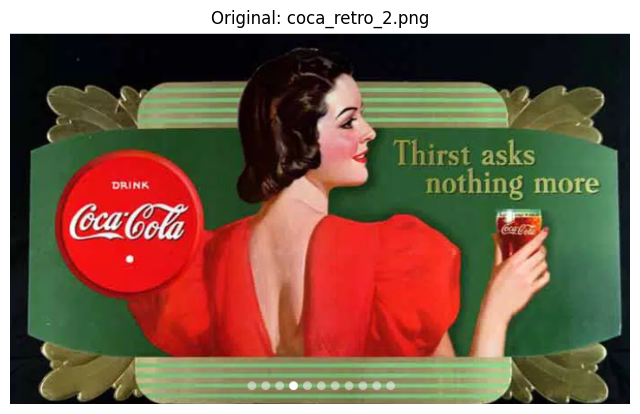

Mostrando el recorte...


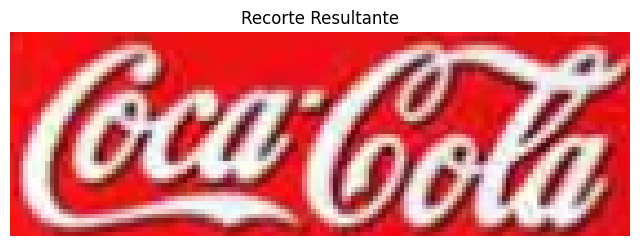

La imagen recortada mide: 140px de ancho y 46px de alto.
Recorte guardado como 'coca_retro_2_recortada.png'


In [25]:
# Llama a la función con tus parámetros
mi_recorte = recortar_y_guardar_imagen('coca_retro_2.png', 'coca_retro_2_recortada.png', x=66, y=195, ancho=140, alto=46)

La imagen original mide: 1389px de ancho y 1389px de alto.


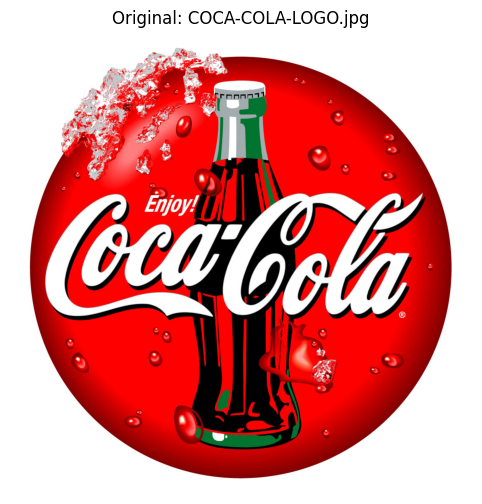

Mostrando el recorte...


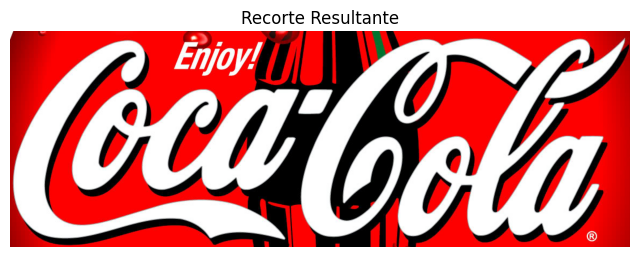

La imagen recortada mide: 1150px de ancho y 400px de alto.
Recorte guardado como 'COCA-COLA-LOGO_recortada.jpg'


In [26]:
# Llama a la función con tus parámetros
mi_recorte = recortar_y_guardar_imagen('COCA-COLA-LOGO.jpg', 'COCA-COLA-LOGO_recortada.jpg', x=100, y=470, ancho=1150, alto=400)

De acuerdo a lo calculado antes, encontramos la relación mínima y la relacion máxima.

In [27]:
ancho_menor = 140
ancho_mayor = 1150
relacion_menor = ancho_menor/ancho1
print('relacion menor:',relacion_menor)

relacion_mayor = ancho_mayor/ancho1
print('relacion mayor:', relacion_mayor)



relacion menor: 0.3794037940379404
relacion mayor: 3.116531165311653


Reutilizamos el procedimiento usado antes. Definimos la funcion *encuentra_logos* que sera usada con los mismos parámetros para todas las imagenes.

In [28]:
def encuentra_logos(nombre_archivo, relacion_menor, relacion_mayor, margen, n):
    print("[INFO] Procesando la plantilla...")
    template = read_image('pattern_recortado.png')
    template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    template_gray = cv2.GaussianBlur(template_gray, (3, 3), 0)
    # Umbral Invertido: el texto oscuro se vuelve blanco, el fondo claro se vuelve negro.
    _, template_binary = cv2.threshold(template_gray, 127, 255, cv2.THRESH_BINARY_INV)
    (tH_orig, tW_orig) = template_binary.shape[:2]

    # --- PASO 2: PRE-PROCESAMIENTO DE LA IMAGEN DE BÚSQUEDA ---
    print("[INFO] Procesando la imagen de búsqueda...")
    image = read_image(nombre_archivo)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_gray = cv2.GaussianBlur(image_gray, (3, 3), 0)
    # Umbral Normal: el texto blanco permanece blanco.
    _, image_binary = cv2.threshold(image_gray, 200, 355, cv2.THRESH_BINARY)

    # Visualizamos las siluetas para verificar
    show_image(template_binary, title="Plantilla Binarizada", cmap_type='gray')
    show_image(image_binary, title="Imagen Binarizada", cmap_type='gray')

    # --- PASO 3: BÚSQUEDA MULTI-ESCALA INFORMADA ---
    print("\n[INFO] Buscando coincidencias...")
    detections = []

    # Define tu escala ideal y el margen de búsqueda

    min_scale = relacion_menor - margen
    max_scale = relacion_mayor + margen

    print(f"Buscando en un rango de escala de {min_scale:.4f} a {max_scale:.4f}")

    for scale in np.linspace(min_scale, max_scale, n):
        new_width = max(1, int(tW_orig * scale))
        new_height = max(1, int(tH_orig * scale))
        resized_template = cv2.resize(template_binary, (new_width, new_height))

        if resized_template.shape[0] > image_binary.shape[0] or resized_template.shape[1] > image_binary.shape[1]:
            continue # Si la plantilla es más grande, salta esta iteración

        result = cv2.matchTemplate(image_binary, resized_template, cv2.TM_CCOEFF_NORMED)

        result = cv2.matchTemplate(image_binary, resized_template, cv2.TM_CCOEFF_NORMED)

        threshold = 0.23
        (y_points, x_points) = np.where(result >= threshold)

        for (x, y) in zip(x_points, y_points):
            detections.append((x, y, x + new_width, y + new_height, result[y, x]))

    # --- PASO 4 y 5: FILTRADO Y DIBUJO ---
    print(f"\n[INFO] Se encontraron {len(detections)} detecciones en bruto.")
    final_logos = non_max_suppression(detections, 0.3)
    print(f"[INFO] Después de NMS, quedaron {len(final_logos)} detecciones finales.")

    for (startX, startY, endX, endY, confidence) in final_logos:
        cv2.rectangle(image, (int(startX), int(startY)), (int(endX), int(endY)), (0, 255, 0), 2)
        cv2.putText(image, f"{confidence:.2f}", (int(startX), int(startY) - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # --- PASO 6: MOSTRAR RESULTADO FINAL ---
    print("\n[INFO] Mostrando resultados finales.")
    show_image(image, title="Resultados Finales")


## Comentarios a cerca de los parámetros elegidos para la función:

El algoritmo es el mismo que el usado en el punto del principio, pero cambian la cantidad de iteraciones en búsqueda de la escala apropiada (de 20 a 2000). Esto es porque ahora hay variación en proporciones de tamaños de los logos en las distintas imágenes.

Se utilizó la imagen pattern_recortada y con estos parametros no tiene falsos positivos y logra detectar todos los logos. Si se usara con la imagen sin recortar, puede que hayan algunos falsos positivos y algunos logos no detectados.

[INFO] Procesando la plantilla...
[INFO] Procesando la imagen de búsqueda...


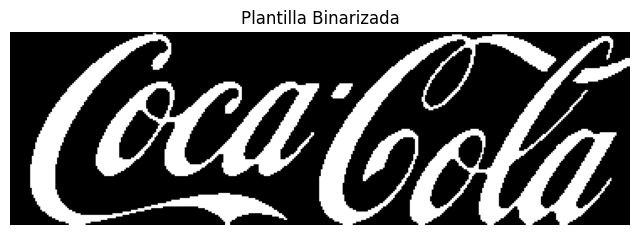

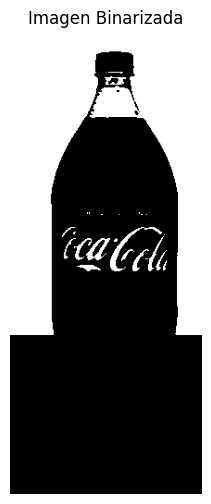


[INFO] Buscando coincidencias...
Buscando en un rango de escala de 0.3694 a 3.1265

[INFO] Se encontraron 600 detecciones en bruto.
[INFO] Después de NMS, quedaron 1 detecciones finales.

[INFO] Mostrando resultados finales.


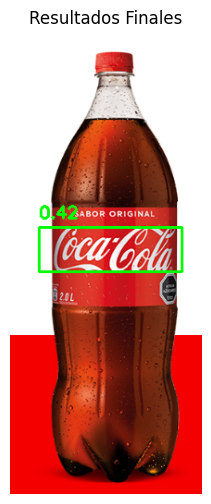

In [29]:
encuentra_logos('coca_logo_1.png',relacion_menor, relacion_mayor, 0.01, 2000)

[INFO] Procesando la plantilla...
[INFO] Procesando la imagen de búsqueda...


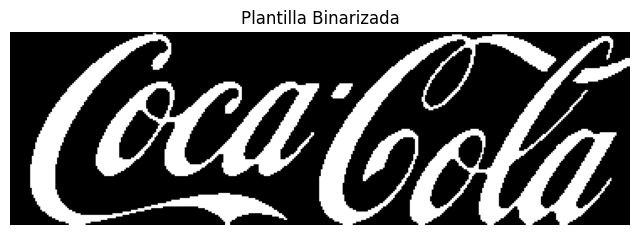

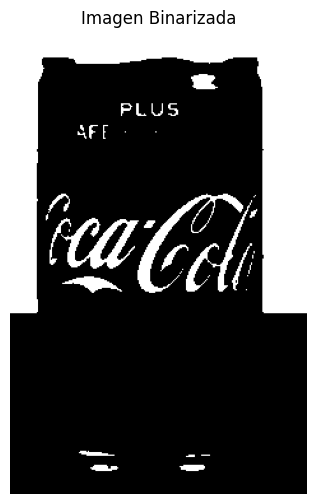


[INFO] Buscando coincidencias...
Buscando en un rango de escala de 0.3694 a 3.1265

[INFO] Se encontraron 25 detecciones en bruto.
[INFO] Después de NMS, quedaron 1 detecciones finales.

[INFO] Mostrando resultados finales.


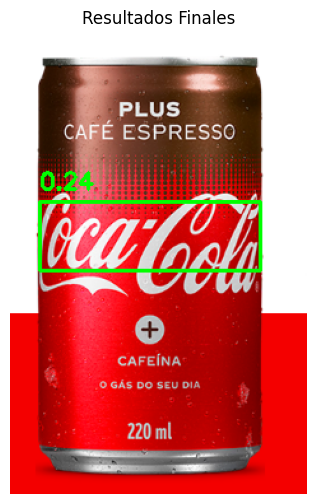

In [30]:
encuentra_logos('coca_logo_2.png',relacion_menor, relacion_mayor, 0.01, 2000)

[INFO] Procesando la plantilla...
[INFO] Procesando la imagen de búsqueda...


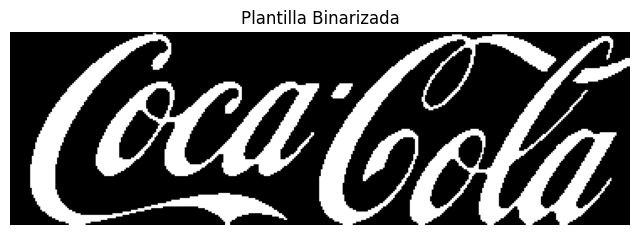

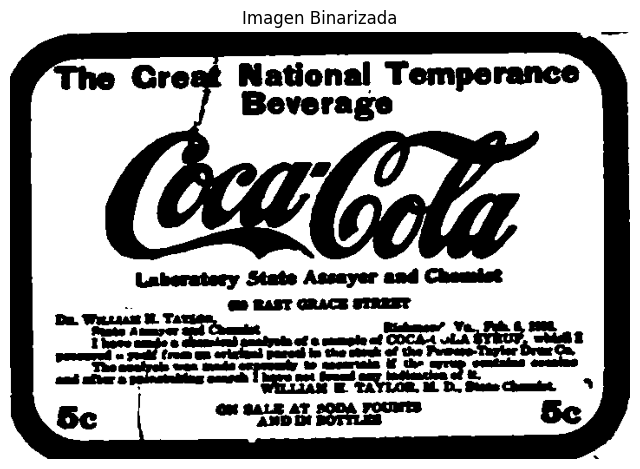


[INFO] Buscando coincidencias...
Buscando en un rango de escala de 0.3694 a 3.1265

[INFO] Se encontraron 157 detecciones en bruto.
[INFO] Después de NMS, quedaron 1 detecciones finales.

[INFO] Mostrando resultados finales.


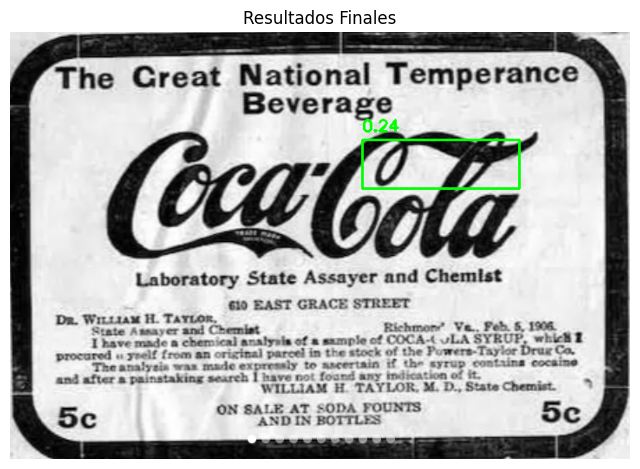

In [31]:
encuentra_logos('coca_retro_1.png',relacion_menor, relacion_mayor, 0.01, 2000)

[INFO] Procesando la plantilla...
[INFO] Procesando la imagen de búsqueda...


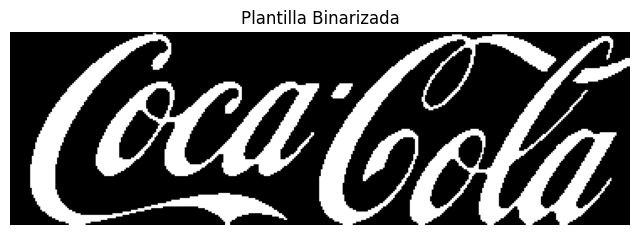

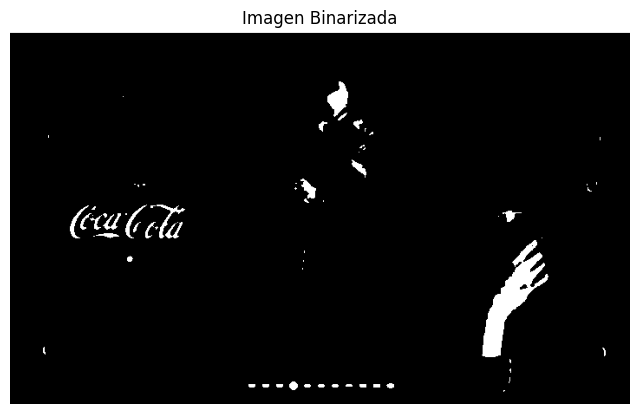


[INFO] Buscando coincidencias...
Buscando en un rango de escala de 0.3694 a 3.1265

[INFO] Se encontraron 1120 detecciones en bruto.
[INFO] Después de NMS, quedaron 1 detecciones finales.

[INFO] Mostrando resultados finales.


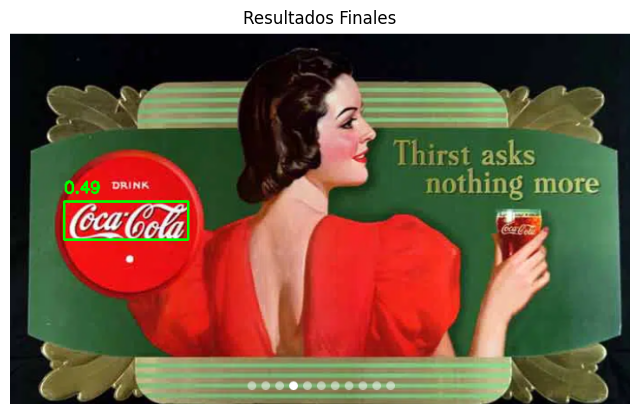

In [32]:
encuentra_logos('coca_retro_2.png',relacion_menor, relacion_mayor, 0.01, 2000)

[INFO] Procesando la plantilla...
[INFO] Procesando la imagen de búsqueda...


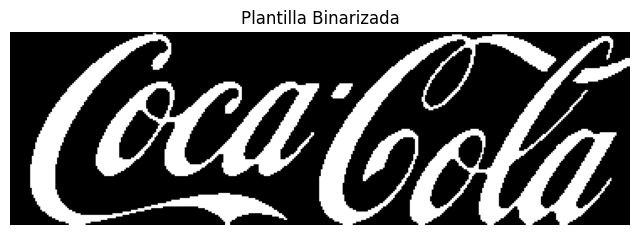

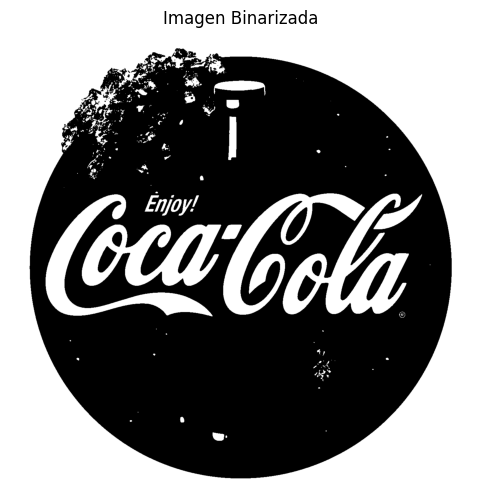


[INFO] Buscando coincidencias...
Buscando en un rango de escala de 0.3694 a 3.1265

[INFO] Se encontraron 46265 detecciones en bruto.
[INFO] Después de NMS, quedaron 1 detecciones finales.

[INFO] Mostrando resultados finales.


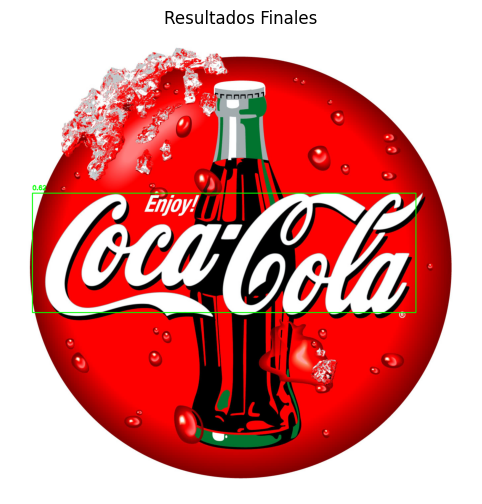

In [33]:
encuentra_logos('COCA-COLA-LOGO.jpg',relacion_menor, relacion_mayor, 0.01, 200)